## The company decided to optimize its advertising costs. To do this, some users were included in a control group (full product advertising), while the test group saw only PSA (social advertising).

### Null hypothesis (H₀): Conversion in the group without advertising is no different from conversion in the group with advertising.

### Alternative hypothesis (H₁): Conversion in the group without advertising differs from conversion in the group with advertising.

## Choosing metrics

The primary metric shows the test's impact, while the secondary metrics help identify potential side effects that could be critical to the business.

Primary metric: **Conversion** – whether a user purchased a product or not (binary). This metric is used to test the hypothesis: "Does disabling ads affect conversion?"

Secondary / guardrail metrics:  **Total ads** - the average number of ads to ensure the control group received fewer ads, and
**Most ads day** - a segmentation metric to see if the day of the week affects conversion.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.api import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency, mannwhitneyu

In [2]:
df = pd.read_csv('marketing_AB.csv', index_col=[0])
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


## Sample size

It is necessary to calculate the sample size for an A/B test to ensure the test is statistically valid.

*The baseline conversion rate* is the current conversion rate of a product, usually taken from historical data (e.g., if 100 out of 1,000 users purchased a product, the baseline is 0.1 (10%))

*The minimum detectable effect (MDE)* is the smallest change you need to notice. (e.g., if disabling ads decreases conversion by 1%, you need to notice it - MDE = 0.01)

*The significance level (alpha)* is the probability of a Type I error—when we mistakenly assume that advertising has an effect when it actually has none (the standard is 0.05 if there are no requirements)

*Statistical power* is the probability of detecting a real effect, if any. Typical values are 0.8 (80%) or 0.9 (90%).
If the power is too low, you might not notice a real drop in conversion. If the power is too high, you need more users than you actually need.

In [3]:
baseline = df[df['test group']=='ad']['converted'].mean()
print(f"Baseline conversion rate: {baseline:.2%}")

Baseline conversion rate: 2.55%


In [4]:
mde = 0.01  # 1% падение конверсии
alpha = 0.05
power = 0.8

To test whether disabling ads impacts purchases, we calculate how many users need to be included in the test and control groups to ensure a significant and statistically significant drop in conversion.

To do this, we measure the effect size - how much the groups differ from each other, but converted into a single numerical metric for statistics—and use the NormalIndPower() statistical calculator, which helps calculate the sample size for an A/B test and takes into account variance and the desired confidence level.

In [5]:
effect_size = proportion_effectsize(baseline, baseline - mde)
effect_size

np.float64(0.07102037687978541)

In [6]:
analysis = NormalIndPower()
n_per_group = analysis.solve_power(effect_size, power=power, alpha=alpha, alternative='two-sided')
n_per_group

3112.222665681538

In [7]:
ad_sample = df[df['test group'] == 'ad'].sample(n=3112, random_state=42)
psa_sample = df[df['test group'] == 'psa'].sample(n=3112, random_state=42)
ab_df = pd.concat([ad_sample, psa_sample], ignore_index=True)

In [8]:
ad_sample['converted'].agg(['mean', 'std']), psa_sample['converted'].agg(['mean', 'std'])

(mean    0.025707
 std     0.158285
 Name: converted, dtype: float64,
 mean    0.020887
 std     0.143029
 Name: converted, dtype: float64)

In [9]:
ab_df.to_csv('ab_df.csv', index=False)

In [10]:
ab_df = pd.read_csv('ab_df.csv')
ab_df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1300427,ad,False,21,Friday,20
1,1197483,ad,False,2,Thursday,20
2,1234257,ad,False,20,Sunday,10
3,1384841,ad,True,47,Friday,14
4,1646962,ad,False,13,Tuesday,13


In [11]:
ab_df['converted'] = ab_df['converted'].astype(int) # для удобства подсчётом переведём в 0/1

In [12]:
# "счётчики успехов" - число покупок в каждой группе
succ_ad = ab_df[ab_df['test group'] == 'ad']['converted'].sum()
succ_psa = ab_df[ab_df['test group'] == 'psa']['converted'].sum()
succ_ad,  succ_psa

(np.int64(80), np.int64(65))

In [13]:
# конверсии в каждой группе (оценки вероятности покупки) 
n = 3112
p_ad = succ_ad / n
p_psa = succ_psa / n
p_ad, p_psa

(np.float64(0.02570694087403599), np.float64(0.020886889460154243))

In [14]:
# наблюдаемая разница - "величина эффекта" которую мы наблюдаем в данных
obs_diff = p_ad - p_psa
obs_diff

np.float64(0.004820051413881747)

# Testing

## Two-proportion Z-test

In [15]:
counts = np.array([succ_ad, succ_psa])
nobs = np.array([n, n])

stat, pvalue = proportions_ztest(counts, nobs, alternative='two-sided')
print(f"Z-test stat = {stat:.4f}, p-value = {pvalue:.4f}")

Z-test stat = 1.2605, p-value = 0.2075


Z-test stat - is the number of standard deviations by which the observed difference between conversions differs from zero (the expected difference at H₀).
(Z = 0 - conversions are almost equal, the further Z is from 0 (in both directions), the greater the difference)
In our case, 1.26 is a small deviation, that is, there is a difference between the groups, but it is insignificant.

p-value - this is the probability of getting such a difference (or a greater difference) in conversion, if in fact there is no difference.
p-value > 0.05, We have no reason to reject the null hypothesis - no statistical differences in conversion between users with and without advertising were found.

## Chi-square test (control/alternative z-test)

In [16]:
table = np.array([[succ_ad, n - succ_ad],
                        [succ_psa, n - succ_psa]])
chi2, p_chi, dof, expected = chi2_contingency(table, correction=False)
print(f"Chi2 = {chi2:.4f}, p-value = {p_chi:.4f}")
print("Expected frequencies:\n", expected)

Chi2 = 1.5887, p-value = 0.2075
Expected frequencies:
 [[  72.5 3039.5]
 [  72.5 3039.5]]


Chi2 stat - shows how much the observed distribution deviates from what we would expect in the absence of the effect (the higher - the greater the deviation from equality)

The results of the Chi2 test are consistent with the results of the Z-test: the differences in conversion between users who saw ads and users who did not see ads are not statistically significant.

## Bootstrap test

To be absolutely sure, let's run one more test—the Bootstrap test. We'll simulate how the sample would behave if we ran the experiment multiple times.

In [18]:
ad = ab_df[ab_df['test group'] == 'ad']['converted']
psa = ab_df[ab_df['test group'] == 'psa']['converted']
n_iterations = 1000
bootstrap_stats = np.zeros(n_iterations)

for i in range(n_iterations):
    control_sample = np.random.choice(ad, n, replace=True)
    treatment_sample = np.random.choice(psa, n, replace=True)
    bootstrap_diff = np.mean(treatment_sample) - np.mean(control_sample)
    bootstrap_stats[i] = bootstrap_diff

ci_low, ci_high = np.percentile(bootstrap_stats, [2.5, 97.5])
p_boot = np.mean(np.abs(bootstrap_stats) >= abs(obs_diff))

print(f"Bootstrap 95% CI for (ad - psa): [{ci_low:.4f}, {ci_high:.4f}]")
print(f"Bootstrap p-value (two-sided) = {p_boot:.4f}")

Bootstrap 95% CI for (ad - psa): [-0.0125, 0.0026]
Bootstrap p-value (two-sided) = 0.5240


Ci (confidence interval) - if we repeated this experiment many times, then in 95% of cases the difference between conversions would lie between−1.25 % и +0.26 %.
The negative range (-0.0125) means that sometimes the ad-free group even converts better.
The positive range (+0.0026) means that sometimes it converts slightly worse.
However, this range falls within zero, meaning the difference could be equally likely in either direction; no effect was detected.

p_boot (p-value) = 0.5240 - In 52% of cases, the difference between groups in random bootstrap replicates was no less than the observed difference.
This means that our observed difference is not unusual—it could easily have arisen by chance.

## Visual confirmation of the result.

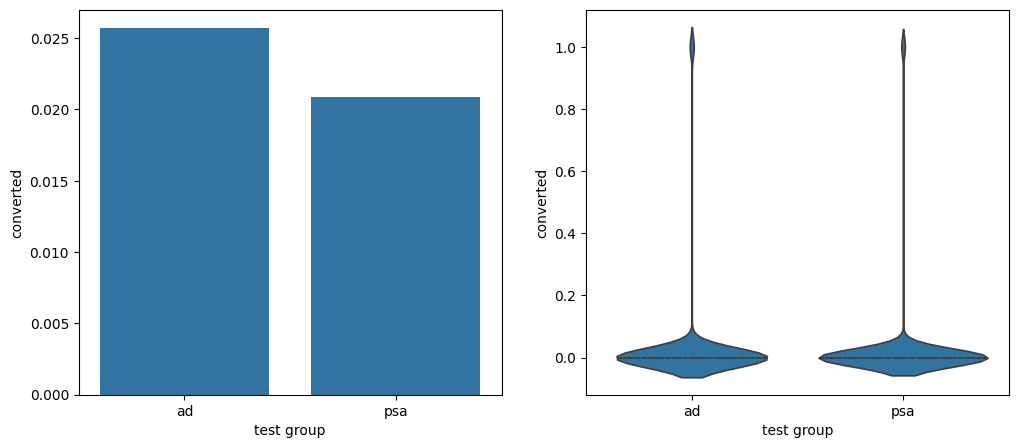

In [21]:
conv_rates = ab_df.groupby('test group')['converted'].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x='test group', y='converted', data=conv_rates, ax=axes[0])
sns.violinplot(x='test group', y='converted', data=ab_df, inner='quartile', ax=axes[1]);

The height of the bars does not differ much - visually confirms the absence of an effect, and the second graph shows how similar the distributions are (shape, median, spread)

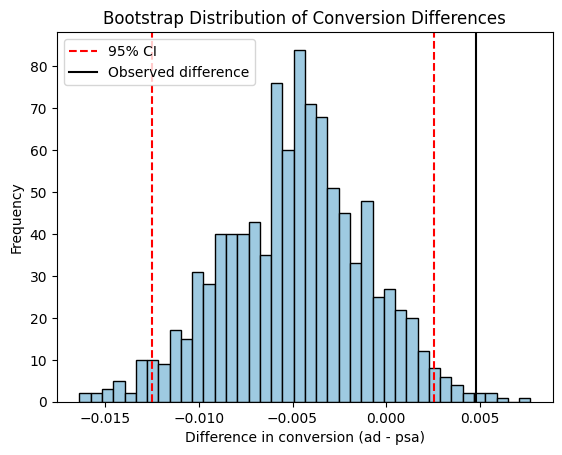

In [22]:
plt.hist(bootstrap_stats, bins=40, color='#9ecae1', edgecolor='black')
plt.axvline(ci_low, color='red', linestyle='--', label='95% CI')
plt.axvline(ci_high, color='red', linestyle='--')
plt.axvline(obs_diff, color='black', linestyle='-', label='Observed difference')
plt.title('Bootstrap Distribution of Conversion Differences')
plt.xlabel('Difference in conversion (ad - psa)')
plt.ylabel('Frequency')
plt.legend();

## Secondary metrics

**total ads** - checking that users in the 'ad' group actually saw more ads than those in 'psa'.
To select a test, let's look at the distribution:

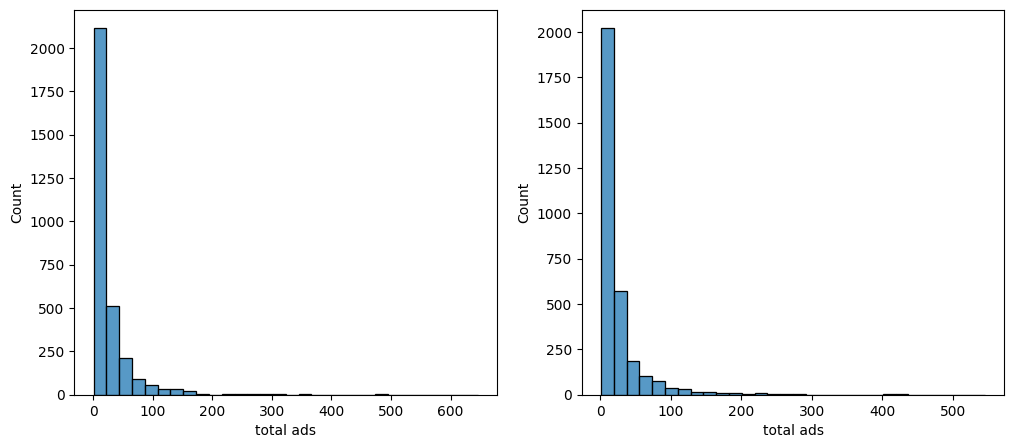

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(ab_df[ab_df['test group'] == 'ad']['total ads'], ax=axes[0], bins=30)
sns.histplot(ab_df[ab_df['test group'] == 'psa']['total ads'], ax=axes[1], bins=30);

The distributions are not similar to normal ones, so we will use the Mann-Whitney test to check whether the distributions differ.

In [24]:
u_stat, p_val = mannwhitneyu(ab_df[ab_df['test group'] == 'ad']['total ads'], ab_df[ab_df['test group'] == 'psa']['total ads'], alternative='two-sided')
print(f"Mann-Whitney U = {u_stat:.4f}, p-value = {p_val:.4f}")

Mann-Whitney U = 5094752.5000, p-value = 0.0004


Mann-Whitney U - test statistics (how much the ranks differ in the two groups)

p-value < 0.05 - this means that the group with advertising actually saw more advertising.

Conduct a **segmentation analysis** by day of the week to see whether the day of the week when a person saw the most ads affects conversion.

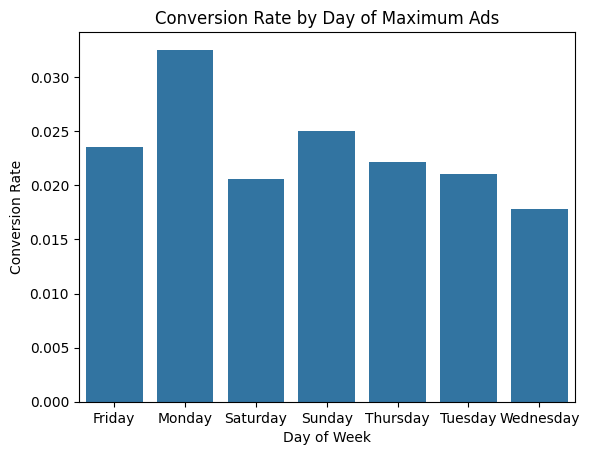

In [25]:
conv_by_day = ab_df.groupby('most ads day')['converted'].mean().reset_index()

sns.barplot(x='most ads day', y='converted', data=conv_by_day)
plt.title('Conversion Rate by Day of Maximum Ads')
plt.ylabel('Conversion Rate')
plt.xlabel('Day of Week');

In general, conversion rates don't vary much across days of the week, except that one might recommend businesses launch their ads only on Mondays.

### SUMMARY

The primary metric *conversion* - did not reveal any statistically significant differences between the groups.

However, an examination of the secondary metrics confirmed that users indeed saw different amounts of ads,

and an analysis by day of the week revealed no significant relationship between ad impression time and conversion.

### Therefore, the hypothesis about the influence of advertising on conversion was not confirmed.